# Houston Flooding
__Historic flood data__
<br>This weather channel article provides count of flood days for each of 20 recent years in Houston.
<br>https://weather.com/storms/severe/news/2019-05-09-houston-americas-flood-capital

In [51]:
import numpy as np
import scipy.stats
import collections
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
days_per_yr_with_flood = [1, 2, 6, 8, 3, 5, 3, 5, 5, 2, 6, 2, 0, 5, 4, 8, 10, 7, 13, 4]
num_yrs = len(days_per_yr_with_flood)
freq_of_observ = collections.Counter(days_per_yr_with_flood)
freq_of_observ = [freq_of_observ[i] for i in range(14)]
# num_yrs = sum(freq_of_observ)
freq_of_observ

[1, 1, 3, 2, 2, 4, 2, 1, 2, 0, 1, 0, 0, 1]

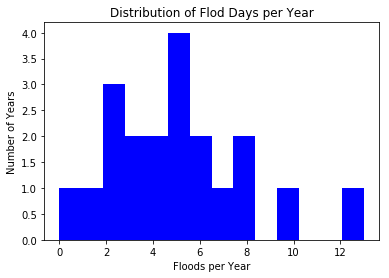

In [86]:
num_bins = len(freq_of_observ)
plt.hist(days_per_yr_with_flood, num_bins, 
                            facecolor='blue', alpha=1.0, align = "mid")
plt.xlabel('Floods per Year')
plt.ylabel('Number of Years')
plt.title('Distribution of Flod Days per Year')
plt.show()

In [4]:
num_flood_days = np.sum(days_per_yr_with_flood)
num_flood_days

99

## Build Poisson distribution
__Avg time between flood days.__

In [5]:
mu = num_flood_days / num_yrs
mu

4.95

In [6]:
freq_expected = [scipy.stats.poisson.pmf(k = i, mu = mu) * num_yrs
                 for i in range(len(freq_of_observ))]
freq_expected[1:5]

[0.7012574839761597, 1.7356122728409953, 2.8637602501876436, 3.543903309607207]

__Check poisson distribution goodness of fit__

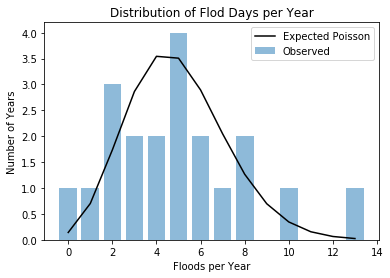

In [7]:
plt.bar(np.arange(len(freq_expected)), freq_of_observ, 
        # facecolor='red', 
        alpha = 0.5, align = "center",
        label = "Observed")
plt.plot(np.arange(len(freq_expected)), freq_expected, 
        linestyle = '-', color = 'black',
        label = 'Expected Poisson')
plt.xlabel('Floods per Year')
plt.ylabel('Number of Years')
plt.title('Distribution of Flod Days per Year')
plt.legend(loc='upper right')
plt.show()

In [8]:
scipy.stats.chisquare(f_obs = freq_of_observ[0:11],
                      f_exp = freq_expected[0:11],
                      ddof = 1) # -1 df cause mu estimated

Power_divergenceResult(statistic=10.429062340331107, pvalue=0.3168790351853755)

__32% is not great but cannot reject at 95% confidence__
<br>Let's roll with this assumption

## Arrival times with exponential
__Check how likely floods are to occur within 1 month of each other__

In [9]:
time_to_investigate = 1/12

prob_of_time_between_occurences = 1 - np.exp(-1 * mu * time_to_investigate) # this amount of time or less

prob_of_time_between_occurences

0.338006803309166

__34% chance of a flood day occuring with 1 month of the previous.__
<br><br><br><br>
__What about 1 year apart or less?__

In [10]:
time_to_investigate = 1

prob_of_time_between_occurences = 1 - np.exp(-1 * mu * time_to_investigate) # this amount of time or less

prob_of_time_between_occurences

0.9929165910709479

__Wow- 99% chance of having a flood within 1 year of the last flood!__

## Other options besides Poisson: Bayes
Prior from Poisson

In [36]:
prior_pmf = [scipy.stats.poisson.pmf(k = i, mu = mu) for i in range(len(freq_of_observ))]
prior_pmf[0:5]

[0.0070834089290521185,
 0.035062874198807985,
 0.08678061364204977,
 0.14318801250938218,
 0.17719516548036035]

In [87]:
likelihood = [freq_of_observ[i] / num_yrs for i in range(len(freq_of_observ))]
likelihood

[0.05, 0.05, 0.15, 0.1, 0.1, 0.2, 0.1, 0.05, 0.1, 0.0, 0.05, 0.0, 0.0, 0.05]

In [65]:
posterior = [a*b for a,b in zip(prior_pmf, likelihood)]
posterior /= np.sum(posterior)

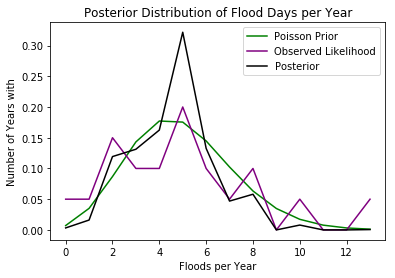

In [66]:
plt.plot(np.arange(len(prior_pmf)), prior_pmf, 
        linestyle = '-', color = 'green',
        label = 'Poisson Prior')
plt.plot(np.arange(len(likelihood)), likelihood, 
        linestyle = '-', color = 'purple',
        label = 'Observed Likelihood')

plt.plot(np.arange(len(posterior)), posterior, 
        linestyle = '-', color = 'black',
        label = 'Posterior')
plt.xlabel('Floods per Year')
plt.ylabel('Number of Years with')
plt.title('Posterior Distribution of Flood Days per Year')
plt.legend(loc='upper right')
plt.show()

Posterior Pr(0 in 1 yr)

In [44]:
posterior[0]

0.0032465283000568

__Differences between posterior and prior__

In [84]:
[a - b for a, b in zip(posterior, prior_pmf)]

[-0.0038368806289953185,
 -0.018992559113526826,
 0.03254147586616282,
 -0.011933714050348238,
 -0.014767971137305963,
 0.14618263097369097,
 -0.012061740426394657,
 -0.05543501175505507,
 -0.0052775499071024065,
 -0.03482780242687804,
 -0.009338287581756614,
 -0.00775789299058708,
 -0.0032001308586171815,
 -0.0006600328600153619]

__Interestingly, the posterior suggests fewer years with no flooding in Houston.__
<br>The prior was already based on the observed average number of events per year.
<br>
<br>Per list of differences immediately above, net effect of updating shape of prior:
<br>1. More probability of years with 2 or 5 flood days.
<br>2. Less probability of years with any other number of flood days.
<br>3. Higher likelihood of a flood within any given time interval (See survival section below). 

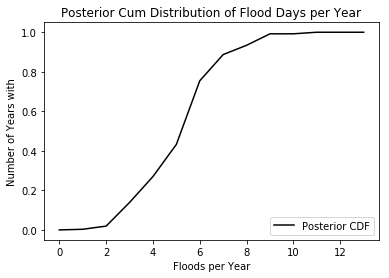

In [49]:
posterior_cdf = [np.sum(posterior[0:i]) for i in range(len(posterior))]
plt.plot(np.arange(len(posterior_cdf)), posterior_cdf, 
        linestyle = '-', color = 'black',
        label = 'Posterior CDF')
plt.xlabel('Floods per Year')
plt.ylabel('Number of Years with')
plt.title('Posterior Cum Distribution of Flood Days per Year')
plt.legend(loc='lower right')
plt.show()

## Nonparametric arrival times
__Making a nonparametric survival function requires making assumptions.__
<br>The principle of deriving the exponential arrival time from the poisson event frequency
<br>hinges on knowing how the Poisson Pr(N=0) scales as the time interval changes.
<br>
<br>We don't directly know how Pr(N=0) changes for the posterior as the time interval changes.
<br>
<br>We could assume the number of flood days per day is simply # of floods per year / 365.
<br>However, this is identical to the poisson assumption of random, independent arrival times 
<br>(which we know is not exactly correct).
<br> Ie. $\lambda$=rt .............(number events = rate * time interval)
<br>
<br>If we want to make this assumption (as it seems the only reasonable assumption available),
<br>then all we need is to adjust $\lambda$ such that the Poisson Pr(0) that we will use in the 
<br>exponential calculation = our Bayesian posterior's Pr(0).
<br>
<br>We can then estimate arrial times as per usual with exponential distribution: 

References:
<br>Poisson & Exp
<br>https://en.wikipedia.org/wiki/Poisson_distribution
<br>https://en.wikipedia.org/wiki/Exponential_distribution
<br>Exp from Poisson
<br>https://stats.stackexchange.com/questions/2092/relationship-between-poisson-and-exponential-distribution
<br>https://www.youtube.com/watch?v=FvsuFa0PkG4
<br>https://www.khanacademy.org/math/statistics-probability/random-variables-stats-library/poisson-distribution/v/poisson-process-1
<br>Survival
<br>https://en.wikipedia.org/wiki/Survival_function
<br>https://en.wikipedia.org/wiki/Survival_analysis
<br>Nonparametric survival (not useful because we don't have continuous sample resolution below 1 year time interval)
<br>https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

In [88]:
### Function to minimize
def Pr_at_zero_error_to_posterior(trial_mu):
    return np.abs(posterior[0] - scipy.stats.poisson.pmf(k = 0, mu = trial_mu))

### Run solver
opt_result = scipy.optimize.minimize_scalar(Pr_at_zero_error_to_posterior)

### Get results
if opt_result['success']:
    representative_mu = opt_result['x']
    print("representative_mu:", np.round(representative_mu, 2))
    print("Or on average, floods are", np.round(1 / representative_mu * 12, 1), "months apart.")
else:
    print("Failed to converge")

representative_mu: 5.73
Or on average, floods are 2.1 months apart.


Pr(0) is lower, $\lambda\$ increased, so probability of floods within 1 month will be higher than before:

In [73]:
time_to_investigate = 1/12
prob_of_time_between_occurences = 1 - np.exp(-1 * representative_mu * time_to_investigate) # this amount of time or less
prob_of_time_between_occurences

0.37967645684244966

Compared to previous probability in 1 month interval:

In [77]:
scipy.stats.expon.cdf(1/12, scale=1/mu)

0.338006803309166

Occurrence within 1 year will be more likely also: 

In [82]:
time_to_investigate = 1
prob_of_time_between_occurences = 1 - np.exp(-1 * representative_mu * time_to_investigate) # this amount of time or less
prob_of_time_between_occurences

0.9967534718625527